# Machine Learning Model # 2 
In this notebook, we assess the capability of predicting 2022 data using 2021 data. This model represents a more realistic scenario where we want to predict future data based on past data.

In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor

seed = 418
np.random.seed(seed)

In [54]:
df = pd.read_csv('../../02_data/02.02_processed/acs_brfss_21_22.csv')
df.drop(columns=['acs21_name'], inplace=True)

In [55]:
df

,fips,brfss21_access2,brfss22_access2,brfss21_checkup,brfss22_checkup,brfss21_csmoking,brfss22_csmoking,brfss21_depression,brfss22_depression,brfss21_diabetes,...,acs21_pct_tp_veh_1,acs22_pct_tp_veh_1,acs21_pct_tp_veh_2,acs22_pct_tp_veh_2,acs21_pct_tp_veh_3,acs22_pct_tp_veh_3,acs21_pop_tot,brfss21_totalpopulation,acs22_pop_tot,brfss22_totalpopulation
0,1001,10.4,9.0,76.0,77.9,16.9,15.4,22.7,24.3,10.7,...,31.5,31.7,33.8,34.7,29.3,29.6,58239,59095,58761,59759
1,1003,9.5,9.6,72.6,76.8,15.0,14.7,23.2,25.1,9.8,...,31.7,31.1,43.2,42.5,22.7,24.2,227131,239294,233420,246435
2,1005,17.2,16.6,76.6,79.1,25.0,21.9,22.6,23.5,15.6,...,33.3,33.3,33.8,32.0,21.7,22.9,25259,24964,24877,24706
3,1007,14.3,13.1,72.7,76.3,22.0,21.8,23.3,26.6,12.4,...,24.7,25.4,37.7,35.2,31.3,31.8,22412,22477,22251,22005
4,1009,13.1,16.1,72.7,75.2,19.6,19.5,24.2,28.0,10.5,...,25.0,24.9,32.1,32.7,38.4,37.6,58884,59041,59077,59512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3063,56037,15.0,12.3,69.9,66.6,17.8,17.9,20.2,22.2,8.8,...,21.6,23.7,37.8,37.2,38.5,37.1,42459,41614,42079,41345
3064,56039,10.4,11.3,66.1,68.3,11.1,11.3,17.4,19.4,6.6,...,30.0,31.1,43.1,41.8,24.3,25.2,23319,23575,23346,23287
3065,56041,13.5,12.6,63.5,66.8,16.8,18.2,20.1,24.2,8.3,...,24.0,25.5,30.3,31.1,42.1,39.6,20514,20635,20546,20712
3066,56043,14.0,13.4,62.7,65.3,16.4,18.5,19.5,22.4,8.4,...,25.0,25.0,38.4,36.1,32.7,34.2,7768,7705,7725,7719


In [56]:
y1 = df[['fips']+[col for col in df.columns if '21' in col]]
y2 = df[['fips']+[col for col in df.columns if '22' in col]]

y1.columns = [col.replace('21', '') for col in y1.columns]
y2.columns = [col.replace('22', '') for col in y2.columns]

print("Y1 Dataframe:")
display(y1)
print("\nY2 Dataframe:")
display(y2)

Y1 Dataframe:


,fips,brfss_access2,brfss_checkup,brfss_csmoking,brfss_depression,brfss_diabetes,brfss_ghlth,brfss_mhlth,brfss_obesity,acs_pct_age_gte65,...,acs_pct_race_white,acs_pct_ses_pov,acs_pct_sex_female,acs_pct_sex_male,acs_pct_tp_veh_0,acs_pct_tp_veh_1,acs_pct_tp_veh_2,acs_pct_tp_veh_3,acs_pop_tot,brfss_totalpopulation
0,1001,10.4,76.0,16.9,22.7,10.7,17.3,18.0,38.9,15.1,...,75.1,13.6,51.6,48.4,5.4,31.5,33.8,29.3,58239,59095
1,1003,9.5,72.6,15.0,23.2,9.8,15.2,17.3,37.2,20.6,...,84.5,9.2,51.2,48.8,2.4,31.7,43.2,22.7,227131,239294
2,1005,17.2,76.6,25.0,22.6,15.6,27.3,20.5,43.4,19.0,...,45.5,26.5,47.1,52.9,11.2,33.3,33.8,21.7,25259,24964
3,1007,14.3,72.7,22.0,23.3,12.4,22.0,19.4,39.6,16.0,...,75.9,16.9,45.1,54.9,6.3,24.7,37.7,31.3,22412,22477
4,1009,13.1,72.7,19.6,24.2,10.5,18.6,18.8,37.7,18.0,...,92.5,13.2,49.9,50.1,4.5,25.0,32.1,38.4,58884,59041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3063,56037,15.0,69.9,17.8,20.2,8.8,14.4,16.1,34.3,12.7,...,86.8,10.5,48.5,51.5,2.1,21.6,37.8,38.5,42459,41614
3064,56039,10.4,66.1,11.1,17.4,6.6,10.0,12.7,21.7,15.5,...,85.2,7.1,47.3,52.7,2.7,30.0,43.1,24.3,23319,23575
3065,56041,13.5,63.5,16.8,20.1,8.3,14.1,15.7,33.3,14.7,...,92.1,8.0,49.1,50.9,3.6,24.0,30.3,42.1,20514,20635
3066,56043,14.0,62.7,16.4,19.5,8.4,13.7,15.3,33.6,22.3,...,85.7,6.6,48.5,51.5,3.9,25.0,38.4,32.7,7768,7705



Y2 Dataframe:


,fips,brfss_access2,brfss_checkup,brfss_csmoking,brfss_depression,brfss_diabetes,brfss_ghlth,brfss_mhlth,brfss_obesity,acs_pct_age_gte65,...,acs_pct_race_white,acs_pct_ses_pov,acs_pct_sex_female,acs_pct_sex_male,acs_pct_tp_veh_0,acs_pct_tp_veh_1,acs_pct_tp_veh_2,acs_pct_tp_veh_3,acs_pop_tot,brfss_totalpopulation
0,1001,9.0,77.9,15.4,24.3,11.3,17.7,18.0,38.4,15.6,...,74.4,11.4,51.2,48.8,4.0,31.7,34.7,29.6,58761,59759
1,1003,9.6,76.8,14.7,25.1,10.2,17.0,18.2,36.8,21.2,...,84.0,10.2,51.1,48.9,2.3,31.1,42.5,24.2,233420,246435
2,1005,16.6,79.1,21.9,23.5,16.0,28.4,21.1,43.8,19.8,...,45.5,24.2,47.9,52.1,11.7,33.3,32.0,22.9,24877,24706
3,1007,13.1,76.3,21.8,26.6,13.3,25.1,21.3,41.4,16.8,...,75.8,20.6,46.5,53.5,7.5,25.4,35.2,31.8,22251,22005
4,1009,16.1,75.2,19.5,28.0,11.6,22.6,21.1,37.3,18.3,...,91.3,14.2,49.4,50.6,4.8,24.9,32.7,37.6,59077,59512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3063,56037,12.3,66.6,17.9,22.2,9.4,15.9,17.3,36.3,13.6,...,84.8,11.7,48.2,51.8,2.0,23.7,37.2,37.1,42079,41345
3064,56039,11.3,68.3,11.3,19.4,7.1,10.6,13.5,22.2,16.6,...,83.2,6.9,48.1,51.9,1.9,31.1,41.8,25.2,23346,23287
3065,56041,12.6,66.8,18.2,24.2,9.0,16.1,18.1,35.5,15.6,...,91.3,6.5,49.2,50.8,3.7,25.5,31.1,39.6,20546,20712
3066,56043,13.4,65.3,18.5,22.4,9.4,17.1,18.1,39.1,23.3,...,86.0,6.7,47.6,52.4,4.7,25.0,36.1,34.2,7725,7719


In [57]:
dv_int = [
    'brfss_diabetes' # BRFSS Age-Adjusted Prevalence
]

dv_struct = [
    'acs_pct_dg_bb_int' #ACS Broadband Adoption
]

structural = [
    'acs_pct_age_gte65',
    'acs_pct_ed_9_12', 
    'acs_pct_ed_asc', 
    'acs_pct_ed_b',
    'acs_pct_ed_gr', 
    'acs_pct_ed_hs', 
    #'diff_acs_pct_ed_lt9', #reference
    'acs_pct_ed_sc', 
    'acs_pct_eth_hisp', 
    'acs_pct_occ_mgt',
    'acs_pct_occ_nat_res', 
    'acs_pct_occ_prod',
    'acs_pct_occ_sales', 
    'acs_pct_occ_svc',
    #'diff_acs_pct_occ_unemp', #reference
    'acs_pct_race_aian',
    'acs_pct_race_asian', 
    'acs_pct_race_black',
    'acs_pct_race_nhopi', 
    'acs_pct_race_other',
    'acs_pct_race_white', 
    'acs_pct_ses_pov',
    'acs_pct_sex_male',
    'acs_pop_tot'
]

intermediate = [
    'structural_internet_adoption',
    'brfss_access2', 
    'brfss_checkup',
    'brfss_csmoking', 
    'brfss_mhlth', 
    'brfss_obesity',
    #'diff_acs_pct_tp_veh_0', reference
    'acs_pct_tp_veh_1',
    'acs_pct_tp_veh_2', 
    'acs_pct_tp_veh_3'
]

index = [
    'fips'
]

                            OLS Regression Results                            
Dep. Variable:      acs_pct_dg_bb_int   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     236.9
Date:                Thu, 22 May 2025   Prob (F-statistic):               0.00
Time:                        11:42:36   Log-Likelihood:                -9112.4
No. Observations:                3068   AIC:                         1.827e+04
Df Residuals:                    3045   BIC:                         1.841e+04
Df Model:                          22                                         
Covariance Type:                  HC1                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  80.4634    

/var/folders/90/wq21gr9d6k90qqqj7y4f_5h40000gn/T/ipykernel_91904/3685276521.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['structural_internet_adoption'] = model.predict(X_struct)


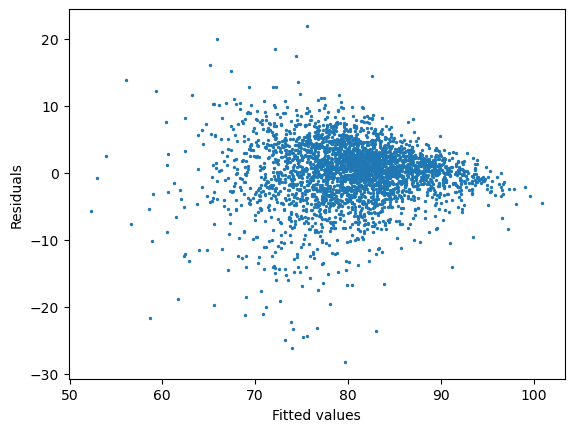

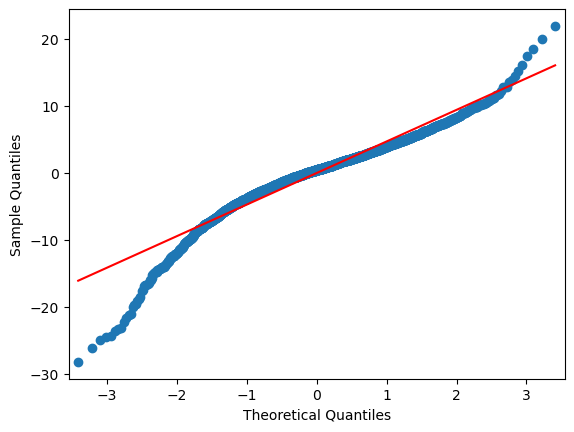

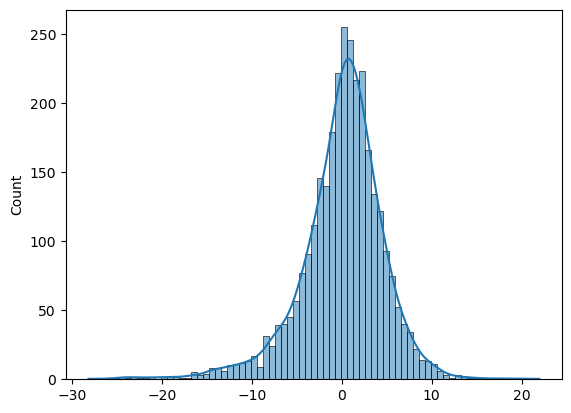

Mean Absolute Error: 3.3775546694476817
Root Mean Squared Error: 4.717103927251543


,Variable,Coef,Std Err,t,95% CI,CI Lower,CI Upper
0,const,80.463,0.085,941.275,"80.296 , 80.631",80.296,80.631
1,acs_pct_age_gte65,-0.505,0.028,-18.038,"-0.56 , -0.45",-0.56,-0.45
2,acs_pct_ed_9_12,0.131,0.093,1.413,"-0.051 , 0.313",-0.051,0.313
3,acs_pct_ed_asc,0.435,0.073,5.959,"0.292 , 0.579",0.292,0.579
4,acs_pct_ed_b,0.410,0.066,6.200,"0.28 , 0.54",0.28,0.54
5,acs_pct_ed_gr,0.510,0.066,7.664,"0.379 , 0.64",0.379,0.64
6,acs_pct_ed_hs,0.203,0.061,3.332,"0.083 , 0.322",0.083,0.322
7,acs_pct_ed_sc,0.389,0.056,6.912,"0.279 , 0.499",0.279,0.499
8,acs_pct_eth_hisp,-0.034,0.020,-1.742,"-0.073 , 0.004",-0.073,0.004
9,acs_pct_occ_mgt,1.027,1.315,0.781,"-1.55 , 3.605",-1.55,3.605


                            OLS Regression Results                            
Dep. Variable:      acs_pct_dg_bb_int   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     214.7
Date:                Thu, 22 May 2025   Prob (F-statistic):               0.00
Time:                        11:42:37   Log-Likelihood:                -8966.0
No. Observations:                3068   AIC:                         1.798e+04
Df Residuals:                    3045   BIC:                         1.812e+04
Df Model:                          22                                         
Covariance Type:                  HC1                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  82.3647    

/var/folders/90/wq21gr9d6k90qqqj7y4f_5h40000gn/T/ipykernel_91904/3685276521.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['structural_internet_adoption'] = model.predict(X_struct)


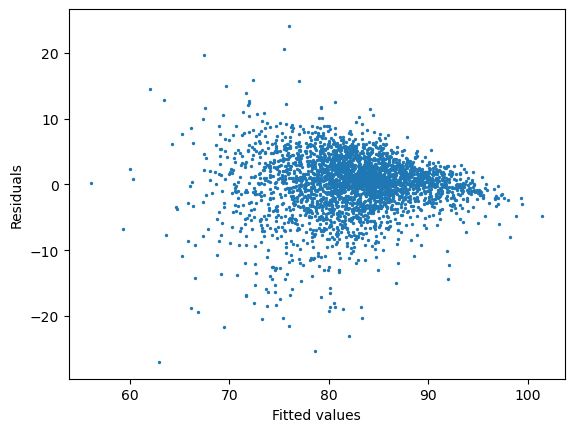

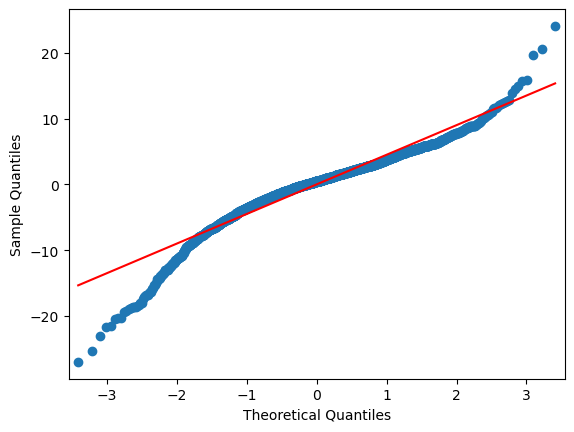

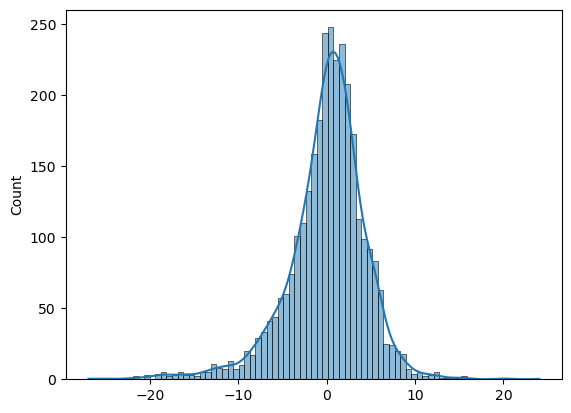

Mean Absolute Error: 3.2110528878771443
Root Mean Squared Error: 4.497374681609584


,Variable,Coef,Std Err,t,95% CI,CI Lower,CI Upper
0,const,82.365,0.082,1010.592,"82.205 , 82.524",82.205,82.524
1,acs_pct_age_gte65,-0.414,0.025,-16.342,"-0.464 , -0.365",-0.464,-0.365
2,acs_pct_ed_9_12,0.205,0.102,2.020,"0.006 , 0.405",0.006,0.405
3,acs_pct_ed_asc,0.409,0.076,5.404,"0.261 , 0.557",0.261,0.557
4,acs_pct_ed_b,0.411,0.070,5.894,"0.274 , 0.547",0.274,0.547
5,acs_pct_ed_gr,0.487,0.075,6.490,"0.34 , 0.634",0.34,0.634
6,acs_pct_ed_hs,0.201,0.069,2.925,"0.066 , 0.335",0.066,0.335
7,acs_pct_ed_sc,0.358,0.065,5.538,"0.232 , 0.485",0.232,0.485
8,acs_pct_eth_hisp,-0.081,0.073,-1.118,"-0.224 , 0.061",-0.224,0.061
9,acs_pct_occ_mgt,0.268,1.263,0.212,"-2.207 , 2.743",-2.207,2.743


In [58]:
analysis_list = [ y1, y2]
for df in analysis_list:
    X_struct = df[structural]
    X_struct = X_struct - X_struct.mean()
    X_struct = sm.add_constant(X_struct)

    y = df[dv_struct]
    #OLS with HC1 robust standard errors
    model = sm.OLS(y, X_struct).fit(cov_type='HC1')

    df['structural_internet_adoption'] = model.predict(X_struct)

    #model summary
    print(model.summary())

    #plto residuals
    fig, ax = plt.subplots()
    ax.scatter(model.fittedvalues, model.resid, s=2) 
    ax.set_xlabel('Fitted values')
    ax.set_ylabel('Residuals')
    plt.show()

    #QQ plot
    fig, ax = plt.subplots()
    sm.qqplot(model.resid, line='s', ax=ax)
    plt.show()

    #distribution of residuals
    sns.histplot(model.resid, kde=True)
    plt.show()


    mae = np.mean(np.abs(model.resid))
    print(f'Mean Absolute Error: {mae}')
    rmse = np.sqrt(np.mean(model.resid**2))
    print(f'Root Mean Squared Error: {rmse}')

    #dataframe with variable names, coefficients, std err, standardised coefficients, t-values, 95% CI
    results = pd.DataFrame(model.params, columns=['Coef'])
    results['Std Err'] = model.bse
    results['t'] = model.tvalues
    results['95% CI'] = model.conf_int()[0]
    #display CI as two string values in the column rounded to 4 decimal places
    results['95% CI'] = results['95% CI'].round(3).astype(str) + ' , ' + model.conf_int()[1].round(3).astype(str)
    #seperate the CI into two columns
    results[['CI Lower', 'CI Upper']] = results['95% CI'].str.split(',', expand=True)
    results = results.reset_index()
    results = results.rename(columns={'index':'Variable'})
    results = results.round(3)
    display(results)    

In [59]:
y1

,fips,brfss_access2,brfss_checkup,brfss_csmoking,brfss_depression,brfss_diabetes,brfss_ghlth,brfss_mhlth,brfss_obesity,acs_pct_age_gte65,...,acs_pct_ses_pov,acs_pct_sex_female,acs_pct_sex_male,acs_pct_tp_veh_0,acs_pct_tp_veh_1,acs_pct_tp_veh_2,acs_pct_tp_veh_3,acs_pop_tot,brfss_totalpopulation,structural_internet_adoption
0,1001,10.4,76.0,16.9,22.7,10.7,17.3,18.0,38.9,15.1,...,13.6,51.6,48.4,5.4,31.5,33.8,29.3,58239,59095,84.013235
1,1003,9.5,72.6,15.0,23.2,9.8,15.2,17.3,37.2,20.6,...,9.2,51.2,48.8,2.4,31.7,43.2,22.7,227131,239294,86.006194
2,1005,17.2,76.6,25.0,22.6,15.6,27.3,20.5,43.4,19.0,...,26.5,47.1,52.9,11.2,33.3,33.8,21.7,25259,24964,67.341536
3,1007,14.3,72.7,22.0,23.3,12.4,22.0,19.4,39.6,16.0,...,16.9,45.1,54.9,6.3,24.7,37.7,31.3,22412,22477,74.128594
4,1009,13.1,72.7,19.6,24.2,10.5,18.6,18.8,37.7,18.0,...,13.2,49.9,50.1,4.5,25.0,32.1,38.4,58884,59041,80.009084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3063,56037,15.0,69.9,17.8,20.2,8.8,14.4,16.1,34.3,12.7,...,10.5,48.5,51.5,2.1,21.6,37.8,38.5,42459,41614,87.158815
3064,56039,10.4,66.1,11.1,17.4,6.6,10.0,12.7,21.7,15.5,...,7.1,47.3,52.7,2.7,30.0,43.1,24.3,23319,23575,93.425891
3065,56041,13.5,63.5,16.8,20.1,8.3,14.1,15.7,33.3,14.7,...,8.0,49.1,50.9,3.6,24.0,30.3,42.1,20514,20635,86.877991
3066,56043,14.0,62.7,16.4,19.5,8.4,13.7,15.3,33.6,22.3,...,6.6,48.5,51.5,3.9,25.0,38.4,32.7,7768,7705,85.961971


In [60]:
y1[index+intermediate]

,fips,structural_internet_adoption,brfss_access2,brfss_checkup,brfss_csmoking,brfss_mhlth,brfss_obesity,acs_pct_tp_veh_1,acs_pct_tp_veh_2,acs_pct_tp_veh_3
0,1001,84.013235,10.4,76.0,16.9,18.0,38.9,31.5,33.8,29.3
1,1003,86.006194,9.5,72.6,15.0,17.3,37.2,31.7,43.2,22.7
2,1005,67.341536,17.2,76.6,25.0,20.5,43.4,33.3,33.8,21.7
3,1007,74.128594,14.3,72.7,22.0,19.4,39.6,24.7,37.7,31.3
4,1009,80.009084,13.1,72.7,19.6,18.8,37.7,25.0,32.1,38.4
...,...,...,...,...,...,...,...,...,...,...
3063,56037,87.158815,15.0,69.9,17.8,16.1,34.3,21.6,37.8,38.5
3064,56039,93.425891,10.4,66.1,11.1,12.7,21.7,30.0,43.1,24.3
3065,56041,86.877991,13.5,63.5,16.8,15.7,33.3,24.0,30.3,42.1
3066,56043,85.961971,14.0,62.7,16.4,15.3,33.6,25.0,38.4,32.7


In [61]:
# y1 is train, y2 is test x = intermediate, y = dv_int
X_train = y1[intermediate]
X_test = y2[intermediate]
y_train = y1[dv_int]
y_train = y_train.values.ravel()
y_test = y2[dv_int]
y_test = y_test.values.ravel()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [62]:
def evaluate_models(X_train, X_test, y_train, y_test):
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge': Ridge(),
        'Lasso': Lasso(),
        'Random Forest': RandomForestRegressor(random_state=seed),
        'Gradient Boosting': GradientBoostingRegressor(random_state=seed),
        'XGBoost': XGBRegressor(random_state=seed)
    }
    
    results = {}
    
    for name, model in models.items():
        # Fit model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        results[name] = {
            'R2': r2_score(y_test, y_pred),
            'MSE': mean_squared_error(y_test, y_pred),
            'MAE': mean_absolute_error(y_test, y_pred),
            'RMSE': root_mean_squared_error(y_test, y_pred),
            'CV_Score': np.mean(cross_val_score(model, X_train, y_train, cv=5))
        }
    
    return results

# Run model evaluation
model_results = evaluate_models(X_train_scaled, X_test_scaled, y_train, y_test)

In [63]:
model_results

{'Linear Regression': {'R2': 0.8085277517332548,
  'MSE': 1.0303517897174317,
  'MAE': 0.782719639194243,
  'RMSE': 1.0150624560673258,
  'CV_Score': np.float64(0.7905960017427347)},
 'Ridge': {'R2': 0.8084548617228057,
  'MSE': 1.0307440259469565,
  'MAE': 0.7828722453375173,
  'RMSE': 1.0152556456119595,
  'CV_Score': np.float64(0.7908182308856428)},
 'Lasso': {'R2': 0.31292221758291827,
  'MSE': 3.6973077257769766,
  'MAE': 1.4708717407803067,
  'RMSE': 1.9228384554551057,
  'CV_Score': np.float64(0.39337315905791675)},
 'Random Forest': {'R2': 0.8146299111725939,
  'MSE': 0.9975148070404173,
  'MAE': 0.7862985658409389,
  'RMSE': 0.9987566305363972,
  'CV_Score': np.float64(0.8335457351009239)},
 'Gradient Boosting': {'R2': 0.8194898200130661,
  'MSE': 0.9713626318976872,
  'MAE': 0.7721232739222923,
  'RMSE': 0.9855773089401395,
  'CV_Score': np.float64(0.8416796201883769)},
 'XGBoost': {'R2': 0.8107778705033539,
  'MSE': 1.0182434349932603,
  'MAE': 0.7948728675170857,
  'RMSE': 

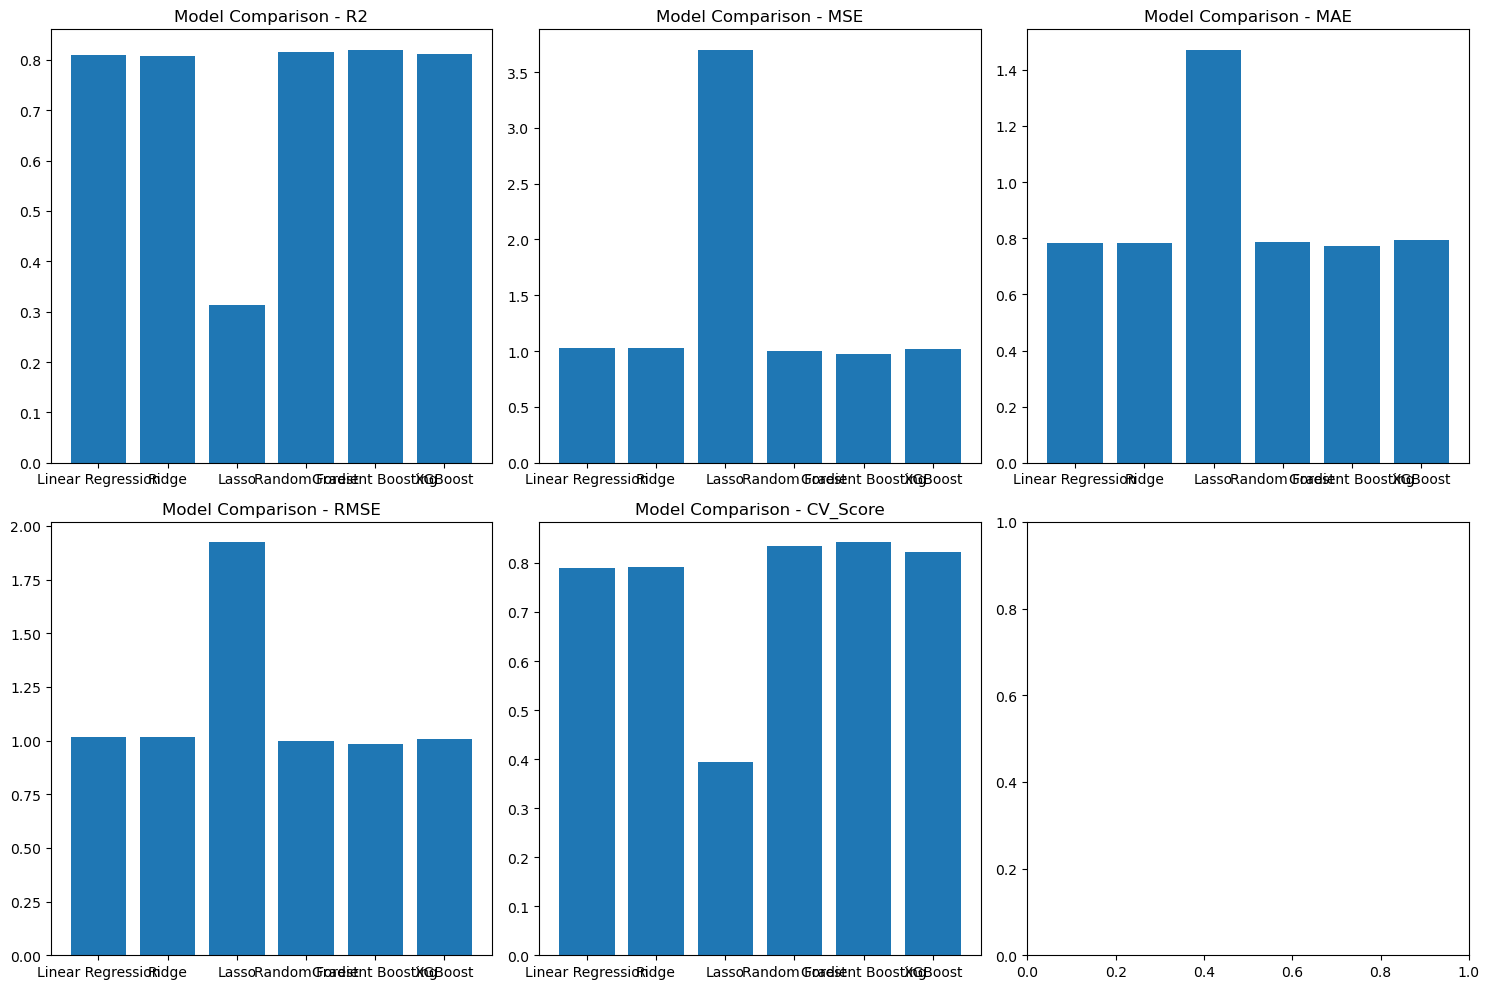

In [64]:
def plot_model_comparison(results):
    metrics = ['R2', 'MSE', 'MAE', 'RMSE', 'CV_Score']
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    for idx, metric in enumerate(metrics):
        values = [results[model][metric] for model in results.keys()]
        ax = axes[idx]
        ax.bar(results.keys(), values)
        ax.set_title(f'Model Comparison - {metric}')
    
    plt.tight_layout()
    plt.show()

plot_model_comparison(model_results)

In [65]:
def perform_grid_search():
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.01, 0.1, 0.3],
        'subsample': [0.8, 0.9, 1.0]
    }
    
    xgb = XGBRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, 
                             cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    
    grid_search.fit(X_train_scaled, y_train)
    
    return grid_search

# Perform grid search
grid_search_results = perform_grid_search()

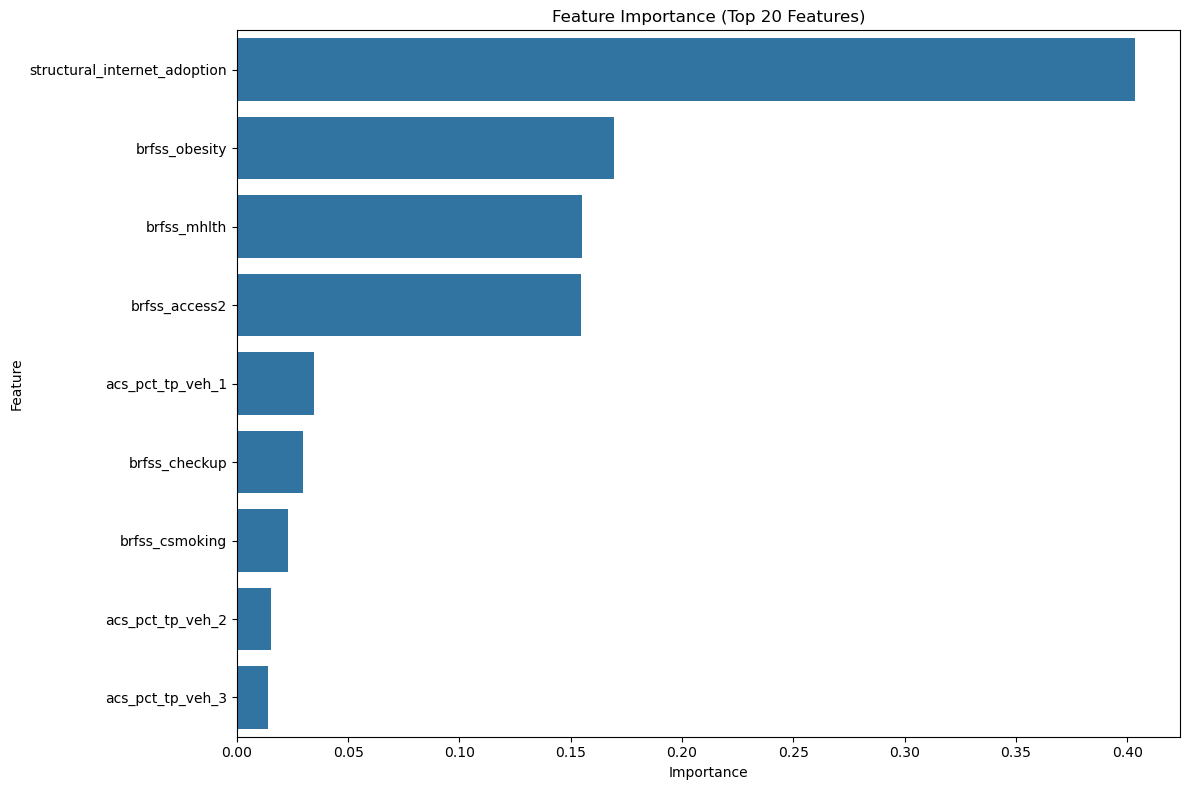

Top 10 most important features:
                        Feature  Importance
0  structural_internet_adoption    0.403552
5                 brfss_obesity    0.169452
4                   brfss_mhlth    0.154905
1                 brfss_access2    0.154811
6              acs_pct_tp_veh_1    0.034859
2                 brfss_checkup    0.029802
3                brfss_csmoking    0.023071
7              acs_pct_tp_veh_2    0.015475
8              acs_pct_tp_veh_3    0.014074


In [66]:
def analyze_feature_importance():
    # Train best model from grid search
    best_model = grid_search_results.best_estimator_
    best_model.fit(X_train_scaled, y_train)
    
    # Get feature importance from the model
    importances = best_model.feature_importances_
    
    # Create a DataFrame to sort and visualize feature importance
    feature_importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
    plt.title('Feature Importance (Top 20 Features)')
    plt.tight_layout()
    plt.show()
    
    # Print top 10 features
    print("Top 10 most important features:")
    print(feature_importance_df.head(10))
    
    return best_model

best_model = analyze_feature_importance()

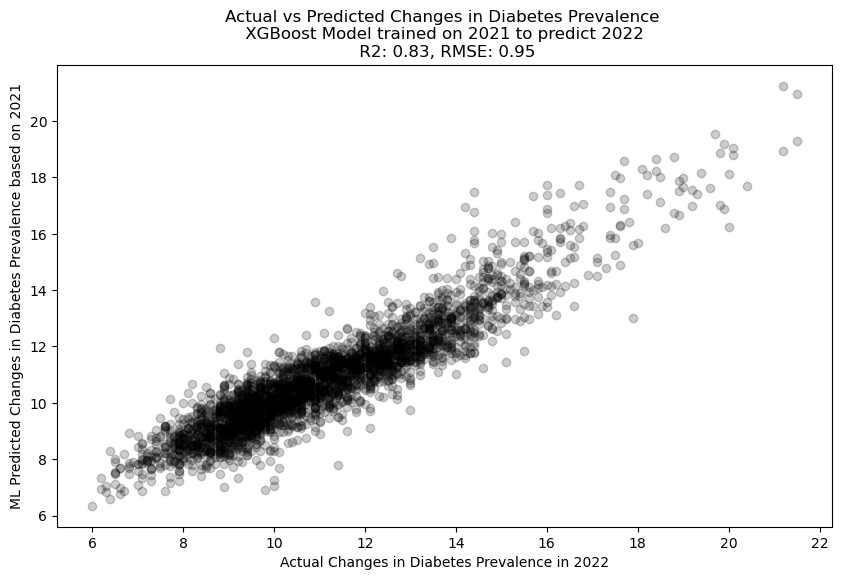

Final Model Evaluation Metrics:
R2: 0.8315
MSE: 0.9065
MAE: 0.7461
RMSE: 0.9521


In [110]:

def evaluate_final_model(model, X_test_scaled, y_test):
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    final_metrics = {
        'R2': r2_score(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': root_mean_squared_error(y_test, y_pred)
    }
    
# Plot actual vs predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.2, color='black')
    plt.xlabel('Actual Changes in Diabetes Prevalence in 2022')
    plt.ylabel('ML Predicted Changes in Diabetes Prevalence based on 2021')
    plt.title(f'Actual vs Predicted Changes in Diabetes Prevalence \n XGBoost Model trained on 2021 to predict 2022 \n R2: {final_metrics["R2"]:.2f}, RMSE: {final_metrics["RMSE"]:.2f}')
    plt.savefig('../../01_docs/01.01_manuscripts/figures/actual_vs_predicted_diabetes_xgboost_y1_y2.png', bbox_inches='tight', dpi=300)
    plt.show()
    #save to 01_docs/01.01_manuscripts/figures
    
    
    return final_metrics

final_metrics = evaluate_final_model(best_model, X_test_scaled, y_test)
#print final metrics
print("Final Model Evaluation Metrics:")
for metric, value in final_metrics.items():
    print(f"{metric}: {value:.4f}")

In [107]:
X_test.columns

Index(['structural_internet_adoption', 'brfss_access2', 'brfss_checkup',
       'brfss_csmoking', 'brfss_mhlth', 'brfss_obesity', 'acs_pct_tp_veh_1',
       'acs_pct_tp_veh_2', 'acs_pct_tp_veh_3'],
      dtype='object')

In [80]:
#shapley values
# Define more human-readable feature names
readable_feature_names = [
    "Internet Adoption",
    "Access to Health Insurance (%)",
    "Annual Checkup with PCP (%)",
    "Current Smoker (%)",
    "Poor Mental Health (%)",
    "Obesity (%)",
    "1 Vehicle Household (%)",
    "2 Vehicle Household (%)",
    "3+ Vehicle Household (%)"
]
import shap
shap.initjs()
explainer = shap.Explainer(best_model, X_train_scaled)
shap_values = explainer(X_test_scaled)
shap.summary_plot(
    shap_values, 
    X_test_scaled, 
    feature_names=readable_feature_names, 
    show=False
)

# Rename x-axis
plt.xlabel("Impact on Diabetes Prevalence Prediction")

# Export plot to 01_docs/01.01_manuscript/figures
plt.savefig("../../01_docs/01.01_manuscripts/figures/shap_summary_plot.png", bbox_inches='tight', dpi=300)
plt.close()
